# Classical methods in order to detect schizophrenia with EEG dataset

## Imports

In [24]:
import os
import mne

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from mne.filter import construct_iir_filter
from mne.preprocessing import ICA
from mne.io import RawArray, read_raw_edf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.decomposition import FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import SGDClassifier, LinearRegression

from tools.psdExtraction import psd_extraction
from tools.MNEtoXYSets import transform

from statsmodels.tsa.ar_model import AutoReg

from lightgbm import LGBMClassifier

## Loading EEG raw data

In [4]:
def load_edf():
    edfs_path = "..\dataverse_files"
    manifest_path = f"{edfs_path}\MANIFEST.txt"

    raw_patients_data = []
    edfs_file_names = [file for file in os.listdir(edfs_path) if file.endswith('.edf')]

    for file_name in edfs_file_names:
        path = f"{edfs_path}/{file_name}"
        raw_data = mne.io.read_raw_edf(path, preload=True, verbose=False)
        raw_patients_data.append(raw_data)

    return (raw_patients_data, edfs_file_names)

## Preprocessing

#### Preprocessing with filtering (Butterworth lowpass filter 6th order with fcut=50Hz)

In [1]:
def preprocessing_by_filtering(signal_array, order = 6, f_pass = 50, f_stop = None, filter_type = 'low'):
    iir_filter = construct_iir_filter(dict(order=order, ftype='butter', output='sos'), f_pass, f_stop, 250, filter_type, verbose=False)

    return [ raw_patient_data
                .filter(l_freq=None, h_freq=None, picks='eeg', method='iir', iir_params=iir_filter, n_jobs=-1, verbose=False) 
            for raw_patient_data in signal_array]

#### Preprocessing with ICA

In [29]:
def preprocessing_by_MNE_ICA(signal_array, n_components = 0.90, method = 'fastica', fit_params={}):
    fitted_patients_data = []
    raw_patients_data = load_edf()
    # Optimalization for ICA
    ica_raw_patients_data = [raw_patient_data.copy().filter(l_freq=1., h_freq=None, verbose = False) for raw_patient_data in signal_array]

    for ica_raw_patient_data in ica_raw_patients_data:
        ica = ICA(n_components = n_components, method = method, verbose = False, fit_params = fit_params)
        ica.fit(ica_raw_patient_data)
        fitted_patients_data.append(ica.apply(ica_raw_patient_data))

    return fitted_patients_data

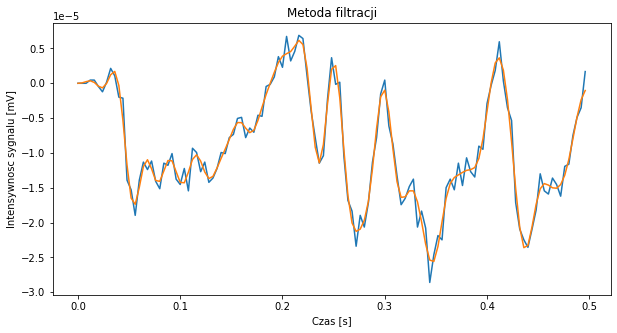

### Preprocessing

In [7]:
def preprocessing(signal_array, method, args):
    ret_value = signal_array
    if method == 'filter':
        ret_value = preprocessing_by_filtering(signal_array, **args)
    elif method == 'mne_ica':
        ret_value = preprocessing_by_MNE_ICA(signal_array, **args)
    else:
        print('If you want to use preprocessing method, please consider using: "filter", "mne_ica"')

    return ret_value

## Extraction

#### PSD

`psd(data)` is available in `tools/psdExtraction.py` file

#### Variance

In [15]:
def variance_extraction(signal_array):
    variance_array = []
    for index, feature in enumerate(signal_array.get_data()):
        variance_array.append(np.var(feature, axis = 1))

    return np.array(variance_array)

#### Autoregression

In [16]:
def autoregresion_extraction(signal_array):
    autoregresion_array = []

    for patient in signal_array:
        coeffs_array = []

        for electrode in patient:
            model = AutoReg(electrode, lags=10)
            result = model.fit()
            coeffs_array.append(result.params.flatten())
    
        autoregresion_array.append(coeffs_array)

    for index, coeffs in enumerate(autoregresion_array):
        autoregresion_array[index] = np.array(coeffs).flatten()

    return np.array(autoregresion_array)

#### L1 Norm

In [17]:
def l1norm_extraction(signal_array):
    l1norm_array = []
    for index, feature in enumerate(signal_array.get_data()):
        l1norm_array.append(np.linalg.norm(feature, ord = 1, axis = 1))
        print(feature, np.linalg.norm(feature, ord = 1, axis = 1))

    return np.array(l1norm_array)

### Extraction

In [8]:
def extraction(method, signal_array):
    ret_value = signal_array
    if method == 'psd':
        ret_value = psd_extraction(signal_array)
    elif method == 'variance':
        ret_value = variance_extraction(signal_array)
    elif method == 'autoregresion':
        ret_value = autoregresion_extraction(signal_array)
    elif method == 'l1norm':
        ret_value = l1norm_extraction(signal_array)
    else:
        print('If you want to use feature extraction method, please consider using: "psd", "variance",\n "autoregresion" or "l1norm_extraction"')

    return ret_value

## Selection

#### _t-test Welch (rank method)_

In [10]:
def t_stats_selection(X, y, n_components=10):
    tstat = np.abs(stats.ttest_ind(X, y, equal_var = False).statistic)
    ind = np.argpartition(tstat, -n_components)[-n_components:]

    return X[:,ind]

#### _PCA_

In [11]:
def pca_selection(X, y, n_components = 5):
    pca = PCA(n_components = n_components)
    return pca.fit_transform(X, y)

#### _SFS_

In [12]:
def sfs_selection(X, y, n_components = 5):
    lda = LinearDiscriminantAnalysis(solver='lsqr')
    sfs = SequentialFeatureSelector(lda, n_features_to_select = n_components)
    return sfs.fit_transform(X, y)

#### Selection

In [9]:
def selection(method, X, y, args):
    ret_value = X
    if float(args['n_components']):
        import math
        args['n_components'] = math.floor(args['n_components'] * X[0].shape[0])

    if method == 't_stats':
        ret_value = t_stats_selection(X, y, **args)
    elif method == 'pca':
        ret_value = pca_selection(X, y, **args)
    elif method == 'sfs':
        ret_value = sfs_selection(X, y, **args)
    else:
        print('If you want to use feature extraction method, please consider using: "t_stats", "pca" or "sfs"')

    return ret_value

## Classification

In [19]:
def classification(estimator, X_train, X_test, y_train, y_test, log = True, show_graphs = False, to_file = False, is_grid_search = False, **args):
    from sklearn.metrics import confusion_matrix

    clr = estimator(**args)
    clr.fit(X_train, y_train)
    y_pred = clr.predict(X_test)
    res_f1_score = f1_score(y_test, y_pred)
    res_acc = clr.score(X_test, y_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    res_err = (fp + fn)/(tp + tn + fn + fp)

    if log:
        print(f"{estimator().__class__.__name__} - Params: {args}")
        print(f"F1 Score: {res_f1_score}")
        print(f"ACC: {res_acc}")

    if to_file:
        from datetime import datetime

        ts_name = f'images/experiment-{estimator().__class__.__name__}-{datetime.timestamp(datetime.now())}'
        if is_grid_search:
            ts_name = f'images/experiment-{estimator().__class__.__name__}-with-gridsearch-{datetime.timestamp(datetime.now())}'

        os.makedirs(f'{ts_name}')
        with open(f'{ts_name}/params', 'w') as file:
            file.write(f'Estimator: {estimator().__class__.__name__}\n')
            file.write(f'Params: {args}\n')
            file.write(f'acc: {res_acc}, f1_score: {res_f1_score}, error: {res_err}')

    if show_graphs:
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        if to_file:
            plt.savefig(f'{ts_name}/{estimator().__class__.__name__}-confussion-matrix.png', dpi=300, facecolor='white', transparent=False)
            
        RocCurveDisplay.from_predictions(y_test, y_pred)
        if to_file:
            plt.savefig(f'{ts_name}/{estimator().__class__.__name__}-roc-curve.png', dpi=300, facecolor='white', transparent=False)

    return (res_acc, res_f1_score, res_err)

## Grid Search

In [14]:
def grid_search(estimator, X_train, y_train, args, log = True):
    clf = GridSearchCV(estimator(), args, n_jobs=-1)
    clf.fit(X_train, y_train)
    if log:
        print("Results from Grid Search")
        print("\n The best estimator across ALL searched params:\n",clf.best_estimator_)
        print("\n The best score across ALL searched params:\n",clf.best_score_)
        print("\n The best parameters across ALL searched params:\n",clf.best_params_)
    return clf.best_params_

## Main program to process

In [5]:
def load_data_and_preprocess(preprocessing_method, preprocessing_parameters = {}):
    signal_array, edfs_file_names = load_edf()

    if preprocessing_method != None:
        X, y = transform(preprocessing(signal_array, preprocessing_method, preprocessing_parameters), edf_file = edfs_file_names)
    else:
        X, y = transform(signal_array, edf_file = edfs_file_names)
    
    return (X, y)

In [11]:
def main_process(
        X, y,
        extraction_method, selection_method, estimator,
        selection_parameters = {}, classification_parameters = {},
        is_grid_search = False, grid_search_params = {},
    ):
    
    if extraction_method != None:
        extraction_X = extraction(extraction_method, X)
    else:
        extraction_X = extraction('variance', X)

    if selection_method != None:
        selected_X = selection(selection_method, extraction_X, y, selection_parameters)
    else:
        selected_X = extraction_X
    
    X_train, X_test, y_train, y_test = train_test_split(selected_X, y, test_size=0.2, shuffle=True, random_state = 42)

    if is_grid_search:
        grid_search_classification_parameters = grid_search(estimator, X_train, y_train, grid_search_params)
        classification_parameters = {**classification_parameters, **grid_search_classification_parameters}
        acc, f1, err = classification(estimator, X_train, X_test, y_train, y_test, **classification_parameters)
        
    else:
        acc, f1, err = classification(estimator, X_train, X_test, y_train, y_test, **classification_parameters)
    
    return (acc, f1, err)

In [21]:
def export_data(data, columns, filename):
    import pandas as pd
    import dataframe_image as dfi

    df = pd.DataFrame.from_records(data, columns = columns).sort_values(by=['accuracy', 'f1'], ascending=False)
    dfi.export(df.style.hide(axis='index'), f'{filename}.png')

#### Preprocessing analyze

In [ ]:
iir_filter_dataset = [
    {'order': 2, 'f_pass': [0.5, 50], 'filter_type': 'bandpass'},
    {'order': 5, 'f_pass': [0.5, 50], 'filter_type': 'bandpass'},
    {'order': 6, 'f_pass': [0.5, 50], 'filter_type': 'bandpass'},
    {'order': 2, 'f_pass': [2, 45], 'filter_type': 'bandpass'},
    {'order': 5, 'f_pass': [2, 45], 'filter_type': 'bandpass'},
    {'order': 6, 'f_pass': [2, 45], 'filter_type': 'bandpass'},
    {'order': 5, 'f_pass': [0.5, 45], 'filter_type': 'bandpass'},
    {'order': 6, 'f_pass': [0.5, 45], 'filter_type': 'bandpass'},
    {'order': 5, 'f_pass': 50, 'filter_type': 'lowpass'},
    {'order': 6, 'f_pass': 50, 'filter_type': 'lowpass'},
]

results_for_filters = []

for filter_parameters in iir_filter_dataset:
    acc, f1, err = main_process(X, y, 'variance', None, KNeighborsClassifier)
    
    results_for_filters.append({
        **filter_parameters,
        'accuracy': acc,
        'f1': f1,
        'error': err,
    })

export_data(results_for_filters, ['order', 'f_pass', 'filter_type', 'accuracy', 'f1', 'error'], 'preprocessing-filtering-results')

In [ ]:
mne_ica_dataset = [
    {'n_components': 19, 'method': 'fastica'},
    {'n_components': 19, 'method': 'infomax', 'fit_params': dict(extended=True)},
    {'n_components': 19, 'method': 'picard', 'fit_params': dict(extended=True)},
]

results_for_ICA = []
for filter_parameters in mne_ica_dataset:
    X, y = load_data_and_preprocess('mne_ica', filter_parameters)
    acc, f1, err = main_process(X, y, 'variance', None, KNeighborsClassifier)

    results_for_ICA.append({
            'method': 'mne_ica',
            **filter_parameters,
            'accuracy': acc,
            'f1': f1,
            'error': err,
        })

export_data(results_for_ICA, ['method', 'accuracy', 'f1', 'error'], 'preprocessing-mne_ica-results')

#### Read data from edf files for all experiments below

In [ ]:
X, y = load_data_and_preprocess('filter', {'n_components': 19, 'method': 'picard', 'fit_params': dict(extended=True)})

#### Extraction analyze

In [ ]:
results_for_extraction = []

for extraction_method in ['power_band', 'variance', 'autoregresion', 'l1norm']:
    acc, f1, err = main_process(X, y, extraction_method, None, KNeighborsClassifier)
    results_for_extraction.append({
        'method': extraction_method,
        'accuracy': acc,
        'f1': f1
    })

export_data(results_for_extraction, ['method', 'accuracy', 'f1'], 'extraction-results')

#### Selection analyze

In [ ]:
results_for_selection = []

for selection_method in ['t_stats', 'pca', 'sfs']:
    for n_componentns in [0.25, 0.5, 0.75, 0.95]:
        acc, f1 = main_process(X, y, 'autoregresion', selection_method, KNeighborsClassifier, selection_parameters= {'n_components': n_componentns})

        results_for_selection.append({
            'method': selection_method,
            'n_components': n_componentns,
            'accuracy': acc,
            'f1': f1
        })

export_data(results_for_selection, ['method', 'n_components', 'accuracy', 'f1'], 'selection-results')

#### Classification analyze

In [ ]:



classificators = [
    {'estimator': KNeighborsClassifier},
    {'estimator': LinearDiscriminantAnalysis},
    {'estimator': QuadraticDiscriminantAnalysis},
    {'estimator': SVC},
    {'estimator': GaussianNB},
    {'estimator': GradientBoostingClassifier},
    {'estimator': AdaBoostClassifier},
    {'estimator': RandomForestClassifier},
    {'estimator': LGBMClassifier},
    {'estimator': DecisionTreeClassifier},
]

results_for_clasification = []

for estimator in classificators:
    acc, f1 = main_process(
        X, 
        y, 
        'autoregresion',
        'pca', 
        estimator['estimator'],
        selection_parameters = {'n_components': 0.25},
        classification_parameters = {'show_graphs': True, 'to_file': True},
    )

    results_for_clasification.append({
        'estimator': estimator['estimator']().__class__.__name__,
        'accuracy': acc,
        'f1': f1,
        'error': err
    })

export_data(results_for_clasification, ['estimator', 'accuracy', 'f1', 'error'], 'classification-results')

#### Grid search classification

In [ ]:
classificators = [
    {'estimator': LinearDiscriminantAnalysis, 'grid_search_params': {"solver": ('svd', 'lsqr', 'eigen'), "n_components": [1]}},
    {'estimator': SVC, 'grid_search_params': {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'C': [x for x in range(1,11)]}},
    {'estimator': GradientBoostingClassifier, 'grid_search_params': {'loss': ('log_loss', 'deviance', 'exponential')}},
    {'estimator': AdaBoostClassifier, 'grid_search_params': {'algorithm': ('SAMME', 'SAMME.R'), 'learning_rate': [1, 25, 50, 100]}},
    {'estimator': RandomForestClassifier, 'grid_search_params': {'criterion': ('gini', 'entropy', 'log_loss'), 'max_features': ('sqrt', 'log2', None)}},
    {'estimator': LGBMClassifier, 'grid_search_params': {"boosting_type":('gbdt', 'dart', 'goss'), "learning_rate":[0.1, 0.25, 0.5, 1]}},
    {'estimator': DecisionTreeClassifier, 'grid_search_params': {"criterion": ('gini', 'entropy', 'log_loss'), "splitter": ('best', 'random'), 'max_features': ('sqrt', 'log2', None)}},
    {'estimator': KNeighborsClassifier, 'grid_search_params': {'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'n_neighbors': [i for i in range(2,8)], 'p': [i for i in range(2,8)]}},
]

results_for_grid_search = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state = 42)

for estimator in classificators:
    acc, f1, err, best_parameters = main_process(
        X, 
        y, 
        'autoregresion',
        'pca', 
        estimator['estimator'],
        selection_parameters = {'n_components': 0.25},
        classification_parameters = {'show_graphs': True, 'to_file': True},
        is_grid_search = True,
        grid_search_params = estimator['grid_search_params']
    )

    res5.append({
        'estimator': estimator['estimator']().__class__.__name__,
        'accuracy': acc,
        'f1': f1,
        'error': err
    })

    export_data(results_for_grid_search, ['estimator', 'accuracy', 'f1', 'error'], 'classification-grid-search-results')

## Plots

In [30]:
raw, _ = load_data_and_preprocess(None)
filter, _ = load_data_and_preprocess('mne_ica', {'n_components': 19, 'method': 'picard', 'fit_params': dict(extended=True)})

Not setting metadata
5771 matching events found
No baseline correction applied
0 bad epochs dropped
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
Fitting ICA took 7.1s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
Fitting ICA took 11.9s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
Fitting ICA took 12.5s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using

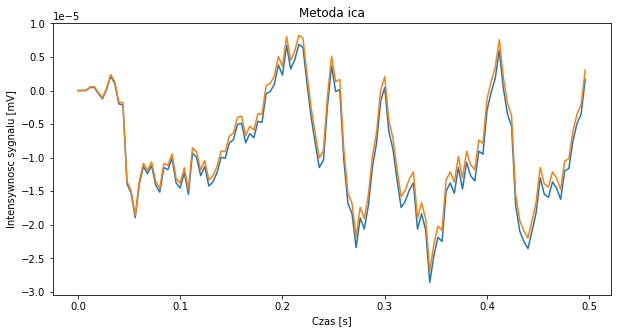

In [33]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [10, 5]
t = np.arange(0, 0.5, 1/250)

fig, axs = plt.subplots()
axs.set_title("Metoda ica")
axs.plot(t, raw[0].get_data()[0][0][:125])
axs.plot(t, filter[0].get_data()[0][0][:125])
axs.set_xlabel("Czas [s]")
axs.set_ylabel("Intensywnosc sygnalu [mV]")

plt.show()

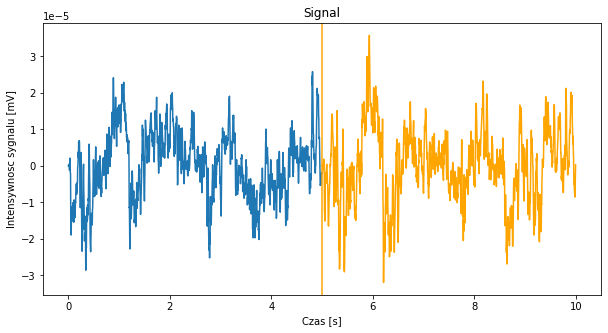

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [10, 5]
t = np.arange(0, 5, 1/250)
t1 = np.arange(5, 10, 1/250)

fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(t, raw[0].get_data()[0][0])
plt.axvline(x=5, color='orange')
axs.plot(t1, raw[0].get_data()[0][1], color='orange')
axs.set_xlabel("Czas [s]")
axs.set_ylabel("Intensywnosc sygnalu [mV]")

plt.show()